# Sat Image Processing

The following notebook will grab satellite images and process them. This involves:

- Computing the NDVI, GCI and Water Indexes for each image.
- Plotting them and saving them.
- Computing the average indexes for each DoY 
- Dividing the images into cell and computing the average indexes for each DoY.
- Maybe rotate them?

In [50]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets
from shapely.geometry import box  # Import box to create a bounding box geometry
import contextily as ctx
import pyproj
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.794485].


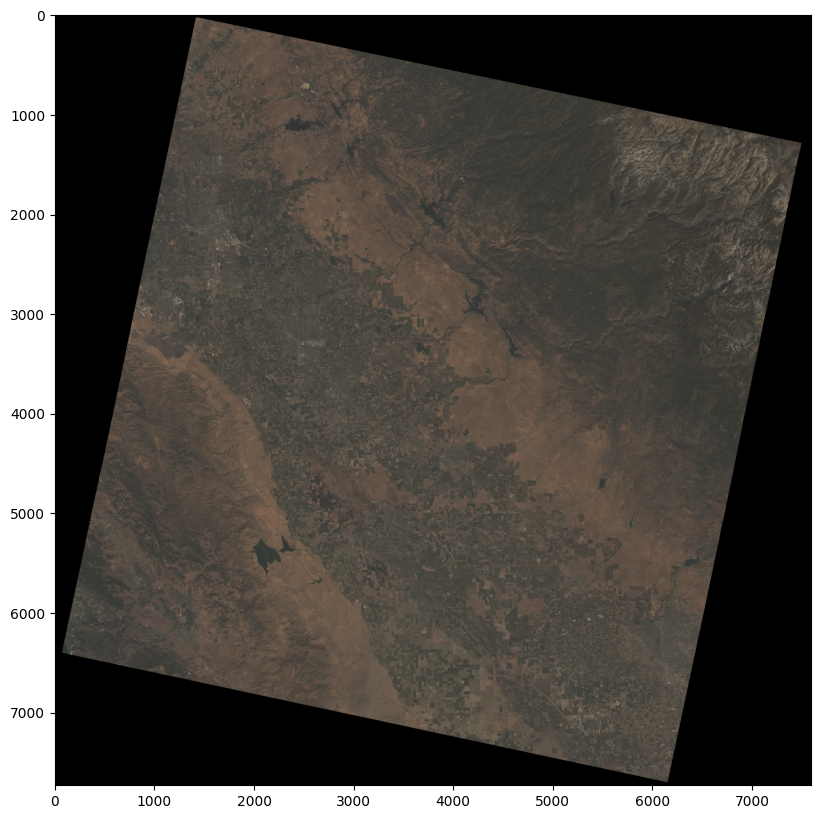

In [145]:
# Paths to the separate RGB TIF files
red_tif_path = './data/sat_images/underlay/LC08_L2SP_043034_20240930_20241005_02_T1_SR_B4.TIF'  # Change this to your red channel TIFF path
green_tif_path = './data/sat_images/underlay/LC08_L2SP_043034_20240930_20241005_02_T1_SR_B3.TIF'  # Change this to your green channel TIFF path
blue_tif_path = './data/sat_images/underlay/LC08_L2SP_043034_20240930_20241005_02_T1_SR_B2.TIF'  # Change this to your blue channel TIFF path
original_tif_path = './data/sat_images/2024-10-06_13-49-16/doy2021337_B5.tif'
scale_factor = 2.75e-05
# Load the RGB channels
with rasterio.open(red_tif_path) as red_src, \
     rasterio.open(green_tif_path) as green_src, \
     rasterio.open(blue_tif_path) as blue_src:

    # Read the RGB bands
    red = red_src.read(1) * scale_factor
    green = green_src.read(1) * scale_factor
    blue = blue_src.read(1) * scale_factor
    
    

    # Stack the RGB bands into a single 3D array
    rgb = np.dstack((red, green, blue))

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the composite RGB image
    ax.imshow(rgb)  # Convert to uint8 for display

plt.show()

C:\Users\manny\AppData\Local\Temp\ipykernel_19500\3410868869.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


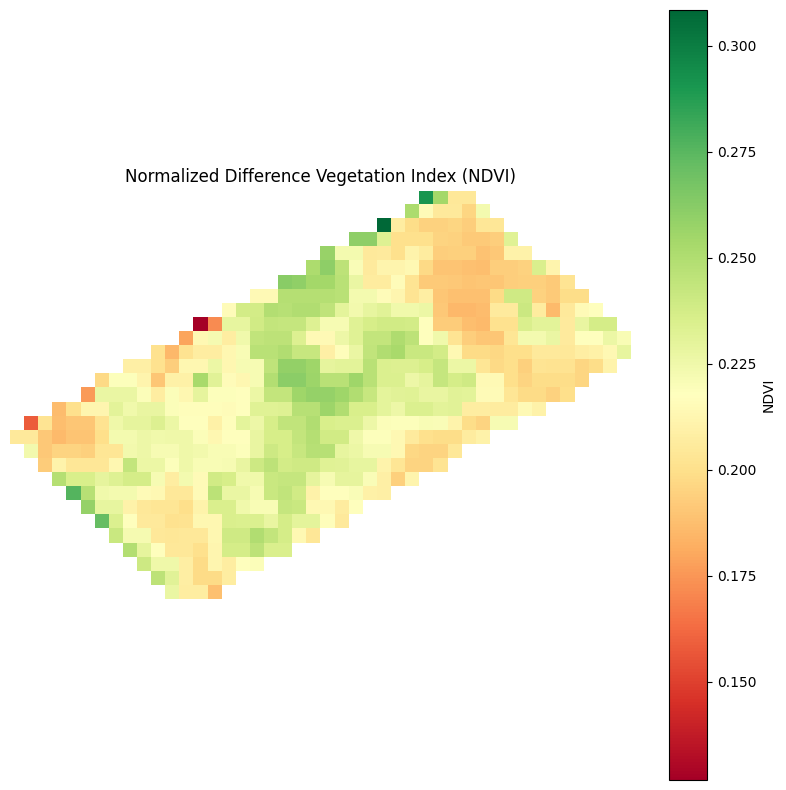

In [127]:
# prompt: Calculate NDVI

# Consider the reflectance scale factor from layer metadata
scale_factor = 2.75e-05

with rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy2024154_B4.tif') as red_band, \
     rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy2024154_B5.tif') as nir_band:

    # Read each band
    red = red_band.read(1).astype('float32') * scale_factor
    nir = nir_band.read(1).astype('float32') * scale_factor

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red) 

    # Plot NDVI
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='NDVI')
    plt.title('Normalized Difference Vegetation Index (NDVI)')
    plt.axis('off')
    plt.show()

In [128]:
def get_mean_parameters(date):
    # NDVI, GCI, NDWI
    
    with rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B4.tif') as red_band, \
         rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B5.tif') as nir_band, \
         rasterio.open('./data/sat_images/2024-10-06_13-49-16/doy' + date + '_B3.tif') as green_band:

        # Read each band
        red = red_band.read(1).astype('float32') * scale_factor
        nir = nir_band.read(1).astype('float32') * scale_factor
        green = green_band.read(1).astype('float32') * scale_factor

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red) 
        gci =  (nir / green) - 1 # (green - red) / (green + red)
        ndwi = (green - nir) / (green + nir) 
        
    return np.nanmean(ndvi), np.nanmean(gci), np.nanmean(ndwi)
        

In [129]:
import os
from datetime import datetime, timedelta



def get_unique_dates_and_raw_strings(directory):
    unique_dates = set()  # Use a set to store unique dates
    raw_date_strings = set()  # Use a set to store raw date strings

    # Iterate through files in the specified directory
    for filename in os.listdir(directory):
        # Check if the filename matches the expected pattern
        if filename.startswith("doy") and filename.endswith(".tif"):
            # Extract the year and day of the year
            year_day = filename[3:10]  # YYYYDDD
            
            # Extract year and day of year
            year = int(year_day[:4])  # YYYY
            day_of_year = int(year_day[4:])  # DDD
            
            # Convert to a date
            date = datetime(year, 1, 1) + timedelta(days=day_of_year - 1)
            unique_dates.add(date.date())  # Add the date to the set
            
            # Add the raw date string (YYYYDDD) to the set
            raw_date_strings.add(year_day)

    # Sort unique dates and create an ordered list of raw date strings
    sorted_unique_dates = sorted(unique_dates)
    ordered_raw_date_strings = [
        f"{date.year}{date.timetuple().tm_yday:03d}"  # Recreate the YYYYDDD format
        for date in sorted_unique_dates
    ]

    return sorted_unique_dates, ordered_raw_date_strings  # Return sorted lists of unique dates and raw date strings


# Specify your directory path here
directory_path = './data/sat_images/2024-10-06_13-49-16/'
unique_dates, raw_date_strings = get_unique_dates_and_raw_strings(directory_path)


In [130]:
all_ndvi = []
all_gci = []
all_ndwi = []

for image_date in raw_date_strings:
    mean_ndvi, mean_gci, mean_ndwi = get_mean_parameters(image_date)
    all_ndvi.append(mean_ndvi)
    all_gci.append(mean_gci)
    all_ndwi.append(mean_ndwi)
    

C:\Users\manny\AppData\Local\Temp\ipykernel_19500\882429652.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
C:\Users\manny\AppData\Local\Temp\ipykernel_19500\882429652.py:15: RuntimeWarning: invalid value encountered in divide
  gci =  (nir / green) - 1 # (green - red) / (green + red)
C:\Users\manny\AppData\Local\Temp\ipykernel_19500\882429652.py:16: RuntimeWarning: invalid value encountered in divide
  ndwi = (green - nir) / (green + nir)


In [131]:
import pandas as pd

# Assuming 'unique_dates' and 'raw_date_strings' have been created as before

# Create a DataFrame
df = pd.DataFrame({
    'Date': unique_dates,  # Datetime objects
    'Raw Date String': raw_date_strings,  # Corresponding raw strings (YYYYDDD)
    'Mean NDVI': all_ndvi,
    'Mean GCI': all_gci,
    'Mean NDWI': all_ndwi
})

# Set the 'Date' column to proper datetime format (though they should already be datetime objects)
df['Date'] = pd.to_datetime(df['Date'])

# Display or further manipulate the dataframe
print(df)

          Date Raw Date String  Mean NDVI  Mean GCI  Mean NDWI
0   2021-11-16         2021320   0.135823  0.325995  -0.134462
1   2021-11-21         2021325   0.165683  0.395763  -0.158441
2   2021-12-03         2021337   0.008444  0.013341  -0.006578
3   2021-12-10         2021344   0.287809  0.735870  -0.262604
4   2021-12-19         2021353   0.271024  0.699758  -0.254080
..         ...             ...        ...       ...        ...
124 2024-08-28         2024241   0.172109  0.704449  -0.259958
125 2024-09-06         2024250   0.169375  0.678861  -0.253004
126 2024-09-13         2024257   0.162695  0.677487  -0.252564
127 2024-09-22         2024266   0.160895  0.656434  -0.246618
128 2024-09-29         2024273   0.159871  0.654356  -0.245982

[129 rows x 5 columns]


In [133]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

<Axes: xlabel='Date'>

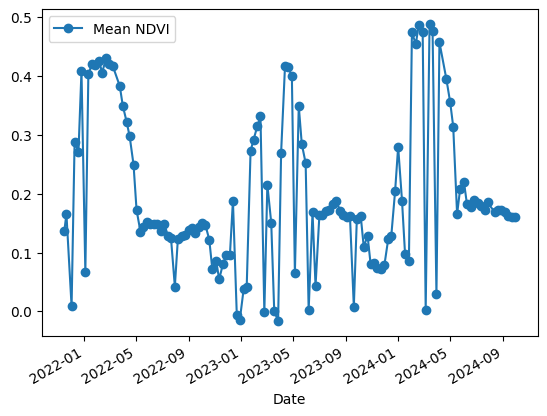

In [134]:
df.plot(x= 'Date', y='Mean NDVI', linestyle = '-', marker = 'o')